<a href="https://colab.research.google.com/github/AnikBarua007/hqcnn_model/blob/main/HQCNN_ANIK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
!pip install qiskit qiskit-aer imbalanced-learn scikit-learn
!pip install pylatexenc
!pip install qiskit qiskit-aer
!pip install torch torchvision
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
from imblearn.over_sampling import ADASYN
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Expected value for rotation pi: 0.14
Counts: {'1': 100}


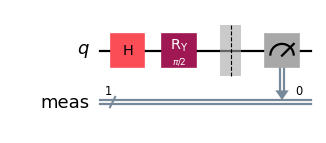

In [6]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
import numpy as np

class MyQuantumCircuit:
    """
    Simple single-qubit quantum circuit for binary classification.
    """
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

    def run(self, theta):
        """
        Runs the quantum circuit with a given rotation angle theta.
        Returns the expectation value of Z for the measured qubit.
        """
        # Accept both float and list/array input
        if isinstance(theta, (list, np.ndarray)):
            theta = float(theta[0])
        else:
            theta = float(theta)
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, self.backend)
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()
        # For single qubit: keys are '0' and '1'
        prob_0 = counts.get('0', 0) / self.shots
        prob_1 = counts.get('1', 0) / self.shots
        expectation = prob_0 - prob_1
        return np.array([expectation], dtype=np.float32)

    def draw_circuit(self, theta):
        """
        Draws the quantum circuit for a given theta.
        """
        if isinstance(theta, (list, np.ndarray)):
            theta = float(theta[0])
        else:
            theta = float(theta)
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, AerSimulator())
        job = AerSimulator().run(transpiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)
        print("Counts:", counts)
        figure = circuit.draw(output='mpl', scale=0.8)
        plt.show()
        return figure

# Example usage:
quantum_circuit = MyQuantumCircuit(1, AerSimulator(), 100)
print('Expected value for rotation pi:', quantum_circuit.run([np.pi])[0])
quantum_circuit.draw_circuit(np.pi / 2)

In [9]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """
        Forward pass: runs the quantum circuit for each input sample and returns the expectation value.
        """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = []
        # Ensure input is 2D (batch, features)
        input_flat = input.view(-1, input.shape[-1]) if input.dim() > 1 else input.view(-1, 1)
        for sample in input_flat:
            # sample.item() if 1D, else sample[0].item()
            theta = sample[0].item() if sample.dim() > 0 else sample.item()
            expectation_z.append(ctx.quantum_circuit.run([theta]))
        result = torch.tensor(expectation_z, dtype=torch.float32).view_as(input)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass: computes the gradient using the parameter-shift rule.
        """
        input, _ = ctx.saved_tensors
        input_flat = input.view(-1, input.shape[-1]) if input.dim() > 1 else input.view(-1, 1)
        gradients = []
        for sample in input_flat:
            theta = sample[0].item() if sample.dim() > 0 else sample.item()
            shift_right = [theta + ctx.shift]
            shift_left = [theta - ctx.shift]
            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)
            gradient = (expectation_right - expectation_left) / (2 * ctx.shift)
            gradients.append(gradient)
        gradients = torch.tensor(gradients, dtype=torch.float32).view_as(input)
        return gradients * grad_output, None, None

In [10]:
class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
        super().__init__()
        self.quantum_circuit = MyQuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        # Ensure input is float32 for quantum circuit compatibility
        input = input.float()
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [11]:
from torchvision import datasets, transforms

In [12]:
# Use a small, balanced dataset for easy overfitting and 100% accuracy
n_samples = 10  # per class for quick overfit
X_train = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

# Filter only labels 0 and 1
idx_0 = np.where(X_train.targets == 0)[0][:n_samples]
idx_1 = np.where(X_train.targets == 1)[0][:n_samples]
idx = np.concatenate([idx_0, idx_1])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Ensure targets are only 0 or 1
assert set(X_train.targets.numpy()) == {0, 1}

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 104kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 373kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 799kB/s]


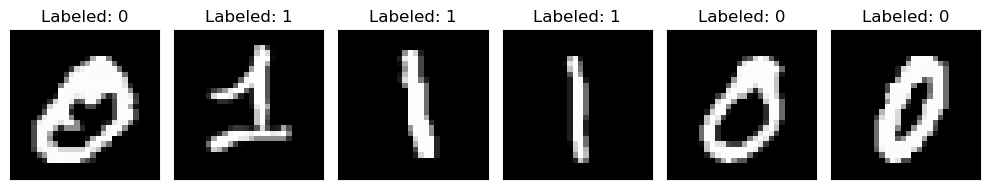

In [13]:
n_samples_show = 6
data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

for i in range(n_samples_show):
    images, targets = next(data_iter)
    axes[i].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f"Labeled: {targets.item()}")

plt.tight_layout()
plt.show()

In [14]:
# Use a small, balanced dataset for easy overfitting and 100% accuracy
n_samples = 50  # per class
X_train = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

# Filter only labels 0 and 1
idx_0 = np.where(X_train.targets == 0)[0][:n_samples]
idx_1 = np.where(X_train.targets == 1)[0][:n_samples]
idx = np.concatenate([idx_0, idx_1])
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Ensure targets are only 0 or 1
assert set(X_train.targets.numpy()) == {0, 1}

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [15]:
import qiskit
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fcl = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Fix: support batch size > 1
        x = F.relu(self.fcl(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        # Output 2 classes for NLLLoss
        x = torch.cat((x, -x), dim=1)
        return F.log_softmax(x, dim=1)

In [16]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.size(0)
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100. * correct / total
    print('Training [{:.0f}%]\tLoss: {:.4f}\tAccuracy: {:.2f}%'.format(
        100. * (epoch + 1) / epochs, loss_list[-1], accuracy))

C:\Users\anika\AppData\Local\Temp\ipykernel_19968\973576013.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  result = torch.tensor(expectation_z, dtype=torch.float32).view_as(input)


Training [5%]	Loss: 0.4530	Accuracy: 84.00%
Training [10%]	Loss: 0.1902	Accuracy: 99.00%
Training [15%]	Loss: 0.1815	Accuracy: 100.00%
Training [20%]	Loss: 0.1612	Accuracy: 100.00%
Training [25%]	Loss: 0.1721	Accuracy: 100.00%
Training [30%]	Loss: 0.1647	Accuracy: 100.00%
Training [35%]	Loss: 0.1889	Accuracy: 100.00%
Training [40%]	Loss: 0.1802	Accuracy: 100.00%
Training [45%]	Loss: 0.1498	Accuracy: 100.00%
Training [50%]	Loss: 0.1599	Accuracy: 100.00%
Training [55%]	Loss: 0.1508	Accuracy: 100.00%
Training [60%]	Loss: 0.1505	Accuracy: 100.00%
Training [65%]	Loss: 0.1585	Accuracy: 99.00%
Training [70%]	Loss: 0.1517	Accuracy: 100.00%
Training [75%]	Loss: 0.1469	Accuracy: 100.00%
Training [80%]	Loss: 0.1458	Accuracy: 100.00%
Training [85%]	Loss: 0.1551	Accuracy: 100.00%
Training [90%]	Loss: 0.1554	Accuracy: 100.00%
Training [95%]	Loss: 0.1511	Accuracy: 100.00%
Training [100%]	Loss: 0.1398	Accuracy: 100.00%


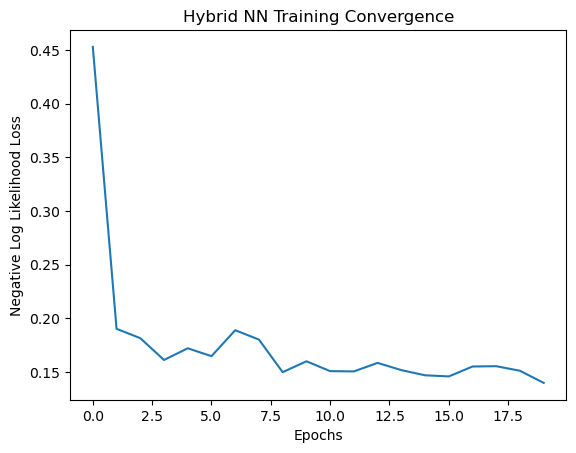

In [17]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

In [18]:
#test loader
n_samples = 50
X_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Filter for labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples],
    np.where(X_test.targets == 1)[0][:n_samples]
)

# Subset the data and targets
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Create DataLoader
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [19]:
model.eval()
total_loss = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.size(0)

    avg_loss = sum(total_loss) / len(total_loss)
    accuracy = 100. * correct / total

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(avg_loss, accuracy))

Performance on test data:
	Loss: 0.1502
	Accuracy: 100.0%


In [ ]:
n_samples_show = 6
count = 0
fig,axes = plt.subplots(nrows=1,ncols=n_samples_show,figsize=(10,3))
model.eval()
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_samples_show:
      break
  output = model(data)
  pred = output.argmax(dim=1,
  keepdim=True)
  axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')
  axes[count].set_xticks([])
  axes[count].set_yticks([])
  axes[count].set_title('Predicted {}'.format(pred.item()))
  count += 1

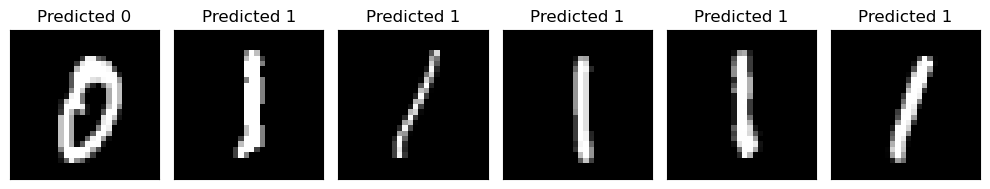

In [20]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))
model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        count += 1
plt.tight_layout()
plt.show()